In [18]:
!pip install scikit-learn
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 19.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 KB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 49.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 63.2 MB/s eta 0:00:00


In [11]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm

# For reproducibility
torch.manual_seed(42)


In [12]:


# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Only normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

batch_size = 128

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [13]:


class DepthwiseSeparableConv(nn.Module):
    """
    Implements a depth-wise separable convolution: depthwise conv followed by pointwise conv.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                   stride=stride, padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class DenseLayer(nn.Module):
    """
    A single layer within a dense block.
    If use_depthwise is True, uses a depth-wise separable conv; otherwise, a traditional conv.
    """
    def __init__(self, in_channels, growth_rate, use_depthwise=True, drop_rate=0.0):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.use_depthwise = use_depthwise
        if self.use_depthwise:
            self.conv = DepthwiseSeparableConv(in_channels, growth_rate, kernel_size=3, stride=1, padding=1)
        else:
            self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        return out

class DenseBlock(nn.Module):
    """
    A dense block where each layer receives as input all previous layers’ outputs.
    """
    def __init__(self, num_layers, in_channels, growth_rate, use_depthwise=True, drop_rate=0.0):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            layer = DenseLayer(in_channels + i * growth_rate, growth_rate, use_depthwise, drop_rate)
            self.layers.append(layer)

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_feature = layer(torch.cat(features, 1))
            features.append(new_feature)
        return torch.cat(features, 1)

class Transition(nn.Module):
    """
    Transition layer used to down-sample the feature maps between dense blocks.
    """
    def __init__(self, in_channels, out_channels, use_depthwise=True):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        # 1x1 convolution (pointwise)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

class DenseNetDS(nn.Module):
    """
    DenseNet-inspired CNN with 4 dense blocks.
    
    Parameters:
      - growth_rate: number of channels to add per DenseLayer.
      - num_init_features: number of channels in the initial convolution.
      - block_layers: list with the number of DenseLayers in each block.
      - num_classes: number of output classes (10 for CIFAR-10).
      - use_depthwise: if True, uses depth-wise separable convolutions.
      - drop_rate: dropout rate.
    """
    def __init__(self, growth_rate=12, num_init_features=32, block_layers=[4, 4, 4, 4],
                 num_classes=10, use_depthwise=True, drop_rate=0.0):
        super(DenseNetDS, self).__init__()
        self.use_depthwise = use_depthwise
        # Initial convolution layer
        if self.use_depthwise:
            self.conv0 = DepthwiseSeparableConv(3, num_init_features, kernel_size=3, stride=1, padding=1)
        else:
            self.conv0 = nn.Conv2d(3, num_init_features, kernel_size=3, stride=1, padding=1, bias=False)
        
        num_features = num_init_features
        self.blocks = nn.ModuleList()
        self.transitions = nn.ModuleList()

        # Build dense blocks with transitions between them (except after the last block)
        for i, num_layers in enumerate(block_layers):
            block = DenseBlock(num_layers, num_features, growth_rate, use_depthwise, drop_rate)
            self.blocks.append(block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_layers) - 1:
                trans = Transition(num_features, num_features // 2, use_depthwise)
                self.transitions.append(trans)
                num_features = num_features // 2

        # Final batch norm, global pooling, and fully connected layer
        self.bn_final = nn.BatchNorm2d(num_features)
        self.relu_final = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.conv0(x)
        for i, block in enumerate(self.blocks):
            x = block(x)
            if i < len(self.transitions):
                x = self.transitions[i](x)
        x = self.relu_final(self.bn_final(x))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [14]:


def train_one_epoch(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch}]")
    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        loop.set_postfix(loss=loss.item(), acc=100.*correct/total)
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def evaluate_model(model, device, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_preds = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    avg_loss = running_loss / total
    acc = 100. * correct / total
    return avg_loss, acc, all_targets, all_preds

def compute_metrics(targets, preds):
    accuracy = accuracy_score(targets, preds)
    precision = precision_score(targets, preds, average='macro', zero_division=0)
    recall = recall_score(targets, preds, average='macro', zero_division=0)
    f1 = f1_score(targets, preds, average='macro', zero_division=0)
    report = classification_report(targets, preds, digits=4, zero_division=0)
    return accuracy, precision, recall, f1, report

def train_and_evaluate(model, device, train_loader, test_loader, criterion, optimizer, num_epochs, model_name="Model"):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_test_acc = 0.0
    best_metrics = None
    print(f"\nTraining {model_name} ...")
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, device, train_loader, optimizer, criterion, epoch)
        test_loss, test_acc, targets, preds = evaluate_model(model, device, test_loader, criterion)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        print(f"{model_name} - Epoch {epoch}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}%, "
              f"Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.2f}%")
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_metrics = (test_loss, test_acc, targets, preds)
    return train_losses, train_accuracies, test_losses, test_accuracies, best_metrics


In [15]:



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_epochs = 100  


criterion = nn.CrossEntropyLoss()

# --- Train Depth-wise Separable Convolution Model ---
use_depthwise = True
model_depth = DenseNetDS(growth_rate=12, num_init_features=32, block_layers=[4, 4, 4, 4],
                         num_classes=10, use_depthwise=use_depthwise, drop_rate=0.0)
model_depth = model_depth.to(device)
optimizer_depth = optim.Adam(model_depth.parameters(), lr=0.001)
print("\nDepth-wise Separable Convolution Model:")
print("Number of trainable parameters:", count_parameters(model_depth))

depth_train_losses, depth_train_accs, depth_test_losses, depth_test_accs, depth_best_metrics = \
    train_and_evaluate(model_depth, device, train_loader, test_loader, criterion, optimizer_depth, num_epochs,
                       model_name="Depth-wise Model")

# --- Train Traditional Convolution Model ---
use_depthwise = False
model_trad = DenseNetDS(growth_rate=12, num_init_features=32, block_layers=[4, 4, 4, 4],
                        num_classes=10, use_depthwise=use_depthwise, drop_rate=0.0)
model_trad = model_trad.to(device)
optimizer_trad = optim.Adam(model_trad.parameters(), lr=0.001)
print("\nTraditional Convolution Model:")
print("Number of trainable parameters:", count_parameters(model_trad))

trad_train_losses, trad_train_accs, trad_test_losses, trad_test_accs, trad_best_metrics = \
    train_and_evaluate(model_trad, device, train_loader, test_loader, criterion, optimizer_trad, num_epochs,
                       model_name="Traditional Model")


Using device: cuda

Depth-wise Separable Convolution Model:
Number of trainable parameters: 34613

Training Depth-wise Model ...


Epoch [1]: 100%|██████████| 391/391 [00:08<00:00, 44.13it/s, acc=40.8, loss=1.14]


Depth-wise Model - Epoch 1: Train Loss = 1.6049, Train Acc = 40.78%, Test Loss = 1.2711, Test Acc = 53.06%


Epoch [2]: 100%|██████████| 391/391 [00:09<00:00, 43.18it/s, acc=58.1, loss=0.976]


Depth-wise Model - Epoch 2: Train Loss = 1.1627, Train Acc = 58.11%, Test Loss = 1.0443, Test Acc = 62.92%


Epoch [3]: 100%|██████████| 391/391 [00:09<00:00, 42.63it/s, acc=64.1, loss=1.11] 


Depth-wise Model - Epoch 3: Train Loss = 0.9978, Train Acc = 64.07%, Test Loss = 0.9624, Test Acc = 66.04%


Epoch [4]: 100%|██████████| 391/391 [00:09<00:00, 41.78it/s, acc=67.6, loss=0.947]


Depth-wise Model - Epoch 4: Train Loss = 0.9033, Train Acc = 67.60%, Test Loss = 0.9168, Test Acc = 67.79%


Epoch [5]: 100%|██████████| 391/391 [00:08<00:00, 43.61it/s, acc=70.6, loss=0.98] 


Depth-wise Model - Epoch 5: Train Loss = 0.8235, Train Acc = 70.62%, Test Loss = 0.8082, Test Acc = 71.57%


Epoch [6]: 100%|██████████| 391/391 [00:08<00:00, 43.79it/s, acc=73, loss=0.798]  


Depth-wise Model - Epoch 6: Train Loss = 0.7656, Train Acc = 73.01%, Test Loss = 0.8037, Test Acc = 72.33%


Epoch [7]: 100%|██████████| 391/391 [00:08<00:00, 43.93it/s, acc=74.7, loss=0.718]


Depth-wise Model - Epoch 7: Train Loss = 0.7196, Train Acc = 74.67%, Test Loss = 0.7485, Test Acc = 73.84%


Epoch [8]: 100%|██████████| 391/391 [00:09<00:00, 42.71it/s, acc=76, loss=0.517]  


Depth-wise Model - Epoch 8: Train Loss = 0.6807, Train Acc = 75.98%, Test Loss = 0.7143, Test Acc = 75.54%


Epoch [9]: 100%|██████████| 391/391 [00:09<00:00, 42.31it/s, acc=77.2, loss=0.765]


Depth-wise Model - Epoch 9: Train Loss = 0.6518, Train Acc = 77.25%, Test Loss = 0.6879, Test Acc = 76.26%


Epoch [10]: 100%|██████████| 391/391 [00:09<00:00, 43.23it/s, acc=78, loss=0.802]  


Depth-wise Model - Epoch 10: Train Loss = 0.6260, Train Acc = 78.01%, Test Loss = 0.6628, Test Acc = 77.01%


Epoch [11]: 100%|██████████| 391/391 [00:09<00:00, 42.12it/s, acc=78.9, loss=0.669]


Depth-wise Model - Epoch 11: Train Loss = 0.6033, Train Acc = 78.93%, Test Loss = 0.6262, Test Acc = 78.56%


Epoch [12]: 100%|██████████| 391/391 [00:08<00:00, 44.50it/s, acc=79.5, loss=0.667]


Depth-wise Model - Epoch 12: Train Loss = 0.5887, Train Acc = 79.45%, Test Loss = 0.6545, Test Acc = 77.69%


Epoch [13]: 100%|██████████| 391/391 [00:09<00:00, 41.13it/s, acc=79.9, loss=0.572]


Depth-wise Model - Epoch 13: Train Loss = 0.5758, Train Acc = 79.88%, Test Loss = 0.6449, Test Acc = 78.45%


Epoch [14]: 100%|██████████| 391/391 [00:09<00:00, 43.07it/s, acc=80.5, loss=0.527]


Depth-wise Model - Epoch 14: Train Loss = 0.5567, Train Acc = 80.54%, Test Loss = 0.6375, Test Acc = 78.24%


Epoch [15]: 100%|██████████| 391/391 [00:09<00:00, 39.73it/s, acc=80.9, loss=0.498]


Depth-wise Model - Epoch 15: Train Loss = 0.5511, Train Acc = 80.90%, Test Loss = 0.5897, Test Acc = 79.82%


Epoch [16]: 100%|██████████| 391/391 [00:09<00:00, 39.46it/s, acc=81.3, loss=0.323]


Depth-wise Model - Epoch 16: Train Loss = 0.5350, Train Acc = 81.34%, Test Loss = 0.5708, Test Acc = 80.74%


Epoch [17]: 100%|██████████| 391/391 [00:09<00:00, 40.85it/s, acc=81.9, loss=0.56] 


Depth-wise Model - Epoch 17: Train Loss = 0.5214, Train Acc = 81.88%, Test Loss = 0.5807, Test Acc = 80.33%


Epoch [18]: 100%|██████████| 391/391 [00:08<00:00, 44.20it/s, acc=82.2, loss=0.471]


Depth-wise Model - Epoch 18: Train Loss = 0.5128, Train Acc = 82.23%, Test Loss = 0.5714, Test Acc = 80.59%


Epoch [19]: 100%|██████████| 391/391 [00:09<00:00, 42.49it/s, acc=82.3, loss=0.5]  


Depth-wise Model - Epoch 19: Train Loss = 0.5054, Train Acc = 82.33%, Test Loss = 0.5793, Test Acc = 80.35%


Epoch [20]: 100%|██████████| 391/391 [00:08<00:00, 45.80it/s, acc=82.7, loss=0.589]


Depth-wise Model - Epoch 20: Train Loss = 0.4967, Train Acc = 82.70%, Test Loss = 0.5534, Test Acc = 80.78%


Epoch [21]: 100%|██████████| 391/391 [00:08<00:00, 43.51it/s, acc=82.8, loss=0.616]


Depth-wise Model - Epoch 21: Train Loss = 0.4925, Train Acc = 82.78%, Test Loss = 0.5672, Test Acc = 80.61%


Epoch [22]: 100%|██████████| 391/391 [00:09<00:00, 42.37it/s, acc=83.1, loss=0.425]


Depth-wise Model - Epoch 22: Train Loss = 0.4824, Train Acc = 83.13%, Test Loss = 0.5515, Test Acc = 81.17%


Epoch [23]: 100%|██████████| 391/391 [00:08<00:00, 44.45it/s, acc=83.4, loss=0.431]


Depth-wise Model - Epoch 23: Train Loss = 0.4764, Train Acc = 83.35%, Test Loss = 0.5651, Test Acc = 81.01%


Epoch [24]: 100%|██████████| 391/391 [00:08<00:00, 44.03it/s, acc=83.5, loss=0.474]


Depth-wise Model - Epoch 24: Train Loss = 0.4727, Train Acc = 83.50%, Test Loss = 0.5739, Test Acc = 80.22%


Epoch [25]: 100%|██████████| 391/391 [00:09<00:00, 41.72it/s, acc=84, loss=0.396]  


Depth-wise Model - Epoch 25: Train Loss = 0.4609, Train Acc = 83.98%, Test Loss = 0.5275, Test Acc = 81.95%


Epoch [26]: 100%|██████████| 391/391 [00:09<00:00, 43.38it/s, acc=84.2, loss=0.461]


Depth-wise Model - Epoch 26: Train Loss = 0.4532, Train Acc = 84.19%, Test Loss = 0.5339, Test Acc = 81.42%


Epoch [27]: 100%|██████████| 391/391 [00:09<00:00, 42.52it/s, acc=84.2, loss=0.41] 


Depth-wise Model - Epoch 27: Train Loss = 0.4547, Train Acc = 84.18%, Test Loss = 0.5289, Test Acc = 82.09%


Epoch [28]: 100%|██████████| 391/391 [00:09<00:00, 41.28it/s, acc=84.4, loss=0.41] 


Depth-wise Model - Epoch 28: Train Loss = 0.4459, Train Acc = 84.35%, Test Loss = 0.5198, Test Acc = 82.51%


Epoch [29]: 100%|██████████| 391/391 [00:08<00:00, 43.60it/s, acc=84.5, loss=0.487]


Depth-wise Model - Epoch 29: Train Loss = 0.4402, Train Acc = 84.54%, Test Loss = 0.5456, Test Acc = 82.02%


Epoch [30]: 100%|██████████| 391/391 [00:09<00:00, 43.33it/s, acc=84.5, loss=0.653]


Depth-wise Model - Epoch 30: Train Loss = 0.4382, Train Acc = 84.53%, Test Loss = 0.5228, Test Acc = 82.30%


Epoch [31]: 100%|██████████| 391/391 [00:09<00:00, 42.20it/s, acc=84.7, loss=0.62] 


Depth-wise Model - Epoch 31: Train Loss = 0.4348, Train Acc = 84.72%, Test Loss = 0.4905, Test Acc = 83.34%


Epoch [32]: 100%|██████████| 391/391 [00:09<00:00, 42.36it/s, acc=85.1, loss=0.356]


Depth-wise Model - Epoch 32: Train Loss = 0.4265, Train Acc = 85.14%, Test Loss = 0.4958, Test Acc = 83.30%


Epoch [33]: 100%|██████████| 391/391 [00:08<00:00, 46.12it/s, acc=85.2, loss=0.591]


Depth-wise Model - Epoch 33: Train Loss = 0.4255, Train Acc = 85.21%, Test Loss = 0.5152, Test Acc = 82.78%


Epoch [34]: 100%|██████████| 391/391 [00:08<00:00, 45.85it/s, acc=85.3, loss=0.415]


Depth-wise Model - Epoch 34: Train Loss = 0.4168, Train Acc = 85.28%, Test Loss = 0.5559, Test Acc = 82.20%


Epoch [35]: 100%|██████████| 391/391 [00:08<00:00, 47.09it/s, acc=85.2, loss=0.432]


Depth-wise Model - Epoch 35: Train Loss = 0.4201, Train Acc = 85.16%, Test Loss = 0.5382, Test Acc = 82.22%


Epoch [36]: 100%|██████████| 391/391 [00:08<00:00, 43.48it/s, acc=85.5, loss=0.417]


Depth-wise Model - Epoch 36: Train Loss = 0.4150, Train Acc = 85.49%, Test Loss = 0.4926, Test Acc = 83.40%


Epoch [37]: 100%|██████████| 391/391 [00:09<00:00, 43.28it/s, acc=86.1, loss=0.501]


Depth-wise Model - Epoch 37: Train Loss = 0.4014, Train Acc = 86.06%, Test Loss = 0.4845, Test Acc = 83.71%


Epoch [38]: 100%|██████████| 391/391 [00:08<00:00, 44.00it/s, acc=85.9, loss=0.382]


Depth-wise Model - Epoch 38: Train Loss = 0.4071, Train Acc = 85.87%, Test Loss = 0.4960, Test Acc = 83.44%


Epoch [39]: 100%|██████████| 391/391 [00:08<00:00, 44.13it/s, acc=85.8, loss=0.563]


Depth-wise Model - Epoch 39: Train Loss = 0.4022, Train Acc = 85.81%, Test Loss = 0.5050, Test Acc = 83.37%


Epoch [40]: 100%|██████████| 391/391 [00:08<00:00, 43.91it/s, acc=85.9, loss=0.387]


Depth-wise Model - Epoch 40: Train Loss = 0.4010, Train Acc = 85.89%, Test Loss = 0.4961, Test Acc = 83.64%


Epoch [41]: 100%|██████████| 391/391 [00:08<00:00, 43.56it/s, acc=86.2, loss=0.32] 


Depth-wise Model - Epoch 41: Train Loss = 0.3942, Train Acc = 86.16%, Test Loss = 0.4801, Test Acc = 84.15%


Epoch [42]: 100%|██████████| 391/391 [00:09<00:00, 42.94it/s, acc=86.2, loss=0.608]


Depth-wise Model - Epoch 42: Train Loss = 0.3956, Train Acc = 86.15%, Test Loss = 0.5014, Test Acc = 83.25%


Epoch [43]: 100%|██████████| 391/391 [00:09<00:00, 41.58it/s, acc=86.3, loss=0.346]


Depth-wise Model - Epoch 43: Train Loss = 0.3883, Train Acc = 86.34%, Test Loss = 0.4768, Test Acc = 83.91%


Epoch [44]: 100%|██████████| 391/391 [00:08<00:00, 43.94it/s, acc=86.6, loss=0.376]


Depth-wise Model - Epoch 44: Train Loss = 0.3815, Train Acc = 86.63%, Test Loss = 0.5203, Test Acc = 82.79%


Epoch [45]: 100%|██████████| 391/391 [00:08<00:00, 44.30it/s, acc=86.5, loss=0.602]


Depth-wise Model - Epoch 45: Train Loss = 0.3869, Train Acc = 86.51%, Test Loss = 0.4959, Test Acc = 83.47%


Epoch [46]: 100%|██████████| 391/391 [00:08<00:00, 46.63it/s, acc=86.5, loss=0.329]


Depth-wise Model - Epoch 46: Train Loss = 0.3809, Train Acc = 86.48%, Test Loss = 0.4898, Test Acc = 83.59%


Epoch [47]: 100%|██████████| 391/391 [00:08<00:00, 43.96it/s, acc=86.9, loss=0.335]


Depth-wise Model - Epoch 47: Train Loss = 0.3745, Train Acc = 86.93%, Test Loss = 0.4841, Test Acc = 84.42%


Epoch [48]: 100%|██████████| 391/391 [00:09<00:00, 41.73it/s, acc=86.9, loss=0.279]


Depth-wise Model - Epoch 48: Train Loss = 0.3780, Train Acc = 86.90%, Test Loss = 0.5079, Test Acc = 82.83%


Epoch [49]: 100%|██████████| 391/391 [00:09<00:00, 43.32it/s, acc=86.8, loss=0.339]


Depth-wise Model - Epoch 49: Train Loss = 0.3731, Train Acc = 86.82%, Test Loss = 0.4827, Test Acc = 83.98%


Epoch [50]: 100%|██████████| 391/391 [00:08<00:00, 45.98it/s, acc=87, loss=0.661]  


Depth-wise Model - Epoch 50: Train Loss = 0.3698, Train Acc = 86.97%, Test Loss = 0.4855, Test Acc = 84.33%


Epoch [51]: 100%|██████████| 391/391 [00:08<00:00, 45.37it/s, acc=86.9, loss=0.485]


Depth-wise Model - Epoch 51: Train Loss = 0.3698, Train Acc = 86.90%, Test Loss = 0.4881, Test Acc = 84.06%


Epoch [52]: 100%|██████████| 391/391 [00:08<00:00, 43.74it/s, acc=87.1, loss=0.359]


Depth-wise Model - Epoch 52: Train Loss = 0.3664, Train Acc = 87.14%, Test Loss = 0.4589, Test Acc = 84.64%


Epoch [53]: 100%|██████████| 391/391 [00:08<00:00, 45.78it/s, acc=87.2, loss=0.37] 


Depth-wise Model - Epoch 53: Train Loss = 0.3648, Train Acc = 87.16%, Test Loss = 0.4864, Test Acc = 84.29%


Epoch [54]: 100%|██████████| 391/391 [00:08<00:00, 43.60it/s, acc=87, loss=0.367]  


Depth-wise Model - Epoch 54: Train Loss = 0.3663, Train Acc = 86.96%, Test Loss = 0.4703, Test Acc = 84.59%


Epoch [55]: 100%|██████████| 391/391 [00:08<00:00, 43.75it/s, acc=87.4, loss=0.452]


Depth-wise Model - Epoch 55: Train Loss = 0.3571, Train Acc = 87.44%, Test Loss = 0.4835, Test Acc = 84.59%


Epoch [56]: 100%|██████████| 391/391 [00:08<00:00, 43.87it/s, acc=87.3, loss=0.299]


Depth-wise Model - Epoch 56: Train Loss = 0.3617, Train Acc = 87.33%, Test Loss = 0.4998, Test Acc = 83.68%


Epoch [57]: 100%|██████████| 391/391 [00:09<00:00, 43.42it/s, acc=87.4, loss=0.607]


Depth-wise Model - Epoch 57: Train Loss = 0.3589, Train Acc = 87.38%, Test Loss = 0.5326, Test Acc = 83.03%


Epoch [58]: 100%|██████████| 391/391 [00:08<00:00, 43.57it/s, acc=87.7, loss=0.373]


Depth-wise Model - Epoch 58: Train Loss = 0.3533, Train Acc = 87.65%, Test Loss = 0.4834, Test Acc = 84.06%


Epoch [59]: 100%|██████████| 391/391 [00:08<00:00, 46.81it/s, acc=87.4, loss=0.449]


Depth-wise Model - Epoch 59: Train Loss = 0.3529, Train Acc = 87.44%, Test Loss = 0.4772, Test Acc = 84.35%


Epoch [60]: 100%|██████████| 391/391 [00:08<00:00, 44.27it/s, acc=87.7, loss=0.32] 


Depth-wise Model - Epoch 60: Train Loss = 0.3467, Train Acc = 87.73%, Test Loss = 0.4714, Test Acc = 84.82%


Epoch [61]: 100%|██████████| 391/391 [00:08<00:00, 45.37it/s, acc=87.7, loss=0.445]


Depth-wise Model - Epoch 61: Train Loss = 0.3504, Train Acc = 87.74%, Test Loss = 0.4621, Test Acc = 85.15%


Epoch [62]: 100%|██████████| 391/391 [00:08<00:00, 45.45it/s, acc=87.7, loss=0.269]


Depth-wise Model - Epoch 62: Train Loss = 0.3479, Train Acc = 87.67%, Test Loss = 0.5066, Test Acc = 83.65%


Epoch [63]: 100%|██████████| 391/391 [00:09<00:00, 43.23it/s, acc=88, loss=0.483]  


Depth-wise Model - Epoch 63: Train Loss = 0.3412, Train Acc = 87.99%, Test Loss = 0.4644, Test Acc = 84.58%


Epoch [64]: 100%|██████████| 391/391 [00:08<00:00, 43.90it/s, acc=88.1, loss=0.298]


Depth-wise Model - Epoch 64: Train Loss = 0.3409, Train Acc = 88.05%, Test Loss = 0.4784, Test Acc = 84.37%


Epoch [65]: 100%|██████████| 391/391 [00:08<00:00, 43.88it/s, acc=88, loss=0.279]  


Depth-wise Model - Epoch 65: Train Loss = 0.3403, Train Acc = 87.96%, Test Loss = 0.4699, Test Acc = 84.68%


Epoch [66]: 100%|██████████| 391/391 [00:08<00:00, 44.35it/s, acc=88, loss=0.493]  


Depth-wise Model - Epoch 66: Train Loss = 0.3406, Train Acc = 87.99%, Test Loss = 0.4604, Test Acc = 84.81%


Epoch [67]: 100%|██████████| 391/391 [00:08<00:00, 43.76it/s, acc=88.1, loss=0.36] 


Depth-wise Model - Epoch 67: Train Loss = 0.3393, Train Acc = 88.09%, Test Loss = 0.4815, Test Acc = 84.38%


Epoch [68]: 100%|██████████| 391/391 [00:08<00:00, 45.74it/s, acc=88.2, loss=0.252]


Depth-wise Model - Epoch 68: Train Loss = 0.3307, Train Acc = 88.21%, Test Loss = 0.4750, Test Acc = 84.73%


Epoch [69]: 100%|██████████| 391/391 [00:08<00:00, 43.76it/s, acc=88.1, loss=0.284]


Depth-wise Model - Epoch 69: Train Loss = 0.3394, Train Acc = 88.11%, Test Loss = 0.4704, Test Acc = 84.75%


Epoch [70]: 100%|██████████| 391/391 [00:08<00:00, 44.40it/s, acc=88.2, loss=0.471]


Depth-wise Model - Epoch 70: Train Loss = 0.3343, Train Acc = 88.21%, Test Loss = 0.4758, Test Acc = 84.54%


Epoch [71]: 100%|██████████| 391/391 [00:09<00:00, 42.48it/s, acc=88.2, loss=0.323]


Depth-wise Model - Epoch 71: Train Loss = 0.3299, Train Acc = 88.21%, Test Loss = 0.4805, Test Acc = 84.32%


Epoch [72]: 100%|██████████| 391/391 [00:09<00:00, 43.16it/s, acc=88.3, loss=0.369]


Depth-wise Model - Epoch 72: Train Loss = 0.3310, Train Acc = 88.34%, Test Loss = 0.4560, Test Acc = 85.91%


Epoch [73]: 100%|██████████| 391/391 [00:09<00:00, 42.82it/s, acc=88.5, loss=0.233]


Depth-wise Model - Epoch 73: Train Loss = 0.3239, Train Acc = 88.52%, Test Loss = 0.4704, Test Acc = 85.16%


Epoch [74]: 100%|██████████| 391/391 [00:09<00:00, 43.12it/s, acc=88.5, loss=0.282]


Depth-wise Model - Epoch 74: Train Loss = 0.3264, Train Acc = 88.50%, Test Loss = 0.4765, Test Acc = 84.84%


Epoch [75]: 100%|██████████| 391/391 [00:08<00:00, 44.09it/s, acc=88.5, loss=0.422]


Depth-wise Model - Epoch 75: Train Loss = 0.3248, Train Acc = 88.46%, Test Loss = 0.4837, Test Acc = 84.93%


Epoch [76]: 100%|██████████| 391/391 [00:08<00:00, 45.00it/s, acc=88.7, loss=0.348]


Depth-wise Model - Epoch 76: Train Loss = 0.3209, Train Acc = 88.73%, Test Loss = 0.4724, Test Acc = 85.31%


Epoch [77]: 100%|██████████| 391/391 [00:08<00:00, 43.56it/s, acc=88.5, loss=0.395]


Depth-wise Model - Epoch 77: Train Loss = 0.3281, Train Acc = 88.50%, Test Loss = 0.4521, Test Acc = 85.42%


Epoch [78]: 100%|██████████| 391/391 [00:08<00:00, 44.95it/s, acc=88.8, loss=0.306]


Depth-wise Model - Epoch 78: Train Loss = 0.3203, Train Acc = 88.79%, Test Loss = 0.4876, Test Acc = 85.01%


Epoch [79]: 100%|██████████| 391/391 [00:08<00:00, 44.44it/s, acc=88.7, loss=0.359]


Depth-wise Model - Epoch 79: Train Loss = 0.3222, Train Acc = 88.72%, Test Loss = 0.4707, Test Acc = 85.02%


Epoch [80]: 100%|██████████| 391/391 [00:09<00:00, 42.53it/s, acc=89, loss=0.236]  


Depth-wise Model - Epoch 80: Train Loss = 0.3153, Train Acc = 89.03%, Test Loss = 0.4669, Test Acc = 85.06%


Epoch [81]: 100%|██████████| 391/391 [00:09<00:00, 42.80it/s, acc=88.8, loss=0.337]


Depth-wise Model - Epoch 81: Train Loss = 0.3156, Train Acc = 88.80%, Test Loss = 0.4851, Test Acc = 84.52%


Epoch [82]: 100%|██████████| 391/391 [00:09<00:00, 43.44it/s, acc=88.8, loss=0.225]


Depth-wise Model - Epoch 82: Train Loss = 0.3167, Train Acc = 88.82%, Test Loss = 0.4753, Test Acc = 84.95%


Epoch [83]: 100%|██████████| 391/391 [00:08<00:00, 44.27it/s, acc=88.9, loss=0.392]


Depth-wise Model - Epoch 83: Train Loss = 0.3181, Train Acc = 88.87%, Test Loss = 0.5113, Test Acc = 83.72%


Epoch [84]: 100%|██████████| 391/391 [00:09<00:00, 43.35it/s, acc=88.8, loss=0.454]


Depth-wise Model - Epoch 84: Train Loss = 0.3175, Train Acc = 88.75%, Test Loss = 0.4494, Test Acc = 85.65%


Epoch [85]: 100%|██████████| 391/391 [00:08<00:00, 44.40it/s, acc=88.8, loss=0.259]


Depth-wise Model - Epoch 85: Train Loss = 0.3114, Train Acc = 88.84%, Test Loss = 0.4945, Test Acc = 84.81%


Epoch [86]: 100%|██████████| 391/391 [00:09<00:00, 42.47it/s, acc=89.3, loss=0.319]


Depth-wise Model - Epoch 86: Train Loss = 0.3091, Train Acc = 89.25%, Test Loss = 0.4550, Test Acc = 85.49%


Epoch [87]: 100%|██████████| 391/391 [00:09<00:00, 42.92it/s, acc=89, loss=0.221]  


Depth-wise Model - Epoch 87: Train Loss = 0.3116, Train Acc = 88.98%, Test Loss = 0.4515, Test Acc = 85.67%


Epoch [88]: 100%|██████████| 391/391 [00:08<00:00, 43.59it/s, acc=89.1, loss=0.24] 


Depth-wise Model - Epoch 88: Train Loss = 0.3089, Train Acc = 89.15%, Test Loss = 0.4568, Test Acc = 85.29%


Epoch [89]: 100%|██████████| 391/391 [00:09<00:00, 42.34it/s, acc=89, loss=0.322]  


Depth-wise Model - Epoch 89: Train Loss = 0.3093, Train Acc = 89.01%, Test Loss = 0.4917, Test Acc = 84.78%


Epoch [90]: 100%|██████████| 391/391 [00:08<00:00, 43.79it/s, acc=89.3, loss=0.407]


Depth-wise Model - Epoch 90: Train Loss = 0.3077, Train Acc = 89.26%, Test Loss = 0.4571, Test Acc = 85.54%


Epoch [91]: 100%|██████████| 391/391 [00:08<00:00, 46.33it/s, acc=89.4, loss=0.18] 


Depth-wise Model - Epoch 91: Train Loss = 0.3039, Train Acc = 89.37%, Test Loss = 0.4408, Test Acc = 85.89%


Epoch [92]: 100%|██████████| 391/391 [00:09<00:00, 43.00it/s, acc=89.2, loss=0.243]


Depth-wise Model - Epoch 92: Train Loss = 0.3077, Train Acc = 89.23%, Test Loss = 0.4504, Test Acc = 85.65%


Epoch [93]: 100%|██████████| 391/391 [00:08<00:00, 44.15it/s, acc=89.3, loss=0.265]


Depth-wise Model - Epoch 93: Train Loss = 0.3046, Train Acc = 89.30%, Test Loss = 0.4704, Test Acc = 85.36%


Epoch [94]: 100%|██████████| 391/391 [00:08<00:00, 44.41it/s, acc=89.2, loss=0.319]


Depth-wise Model - Epoch 94: Train Loss = 0.3031, Train Acc = 89.18%, Test Loss = 0.4510, Test Acc = 85.78%


Epoch [95]: 100%|██████████| 391/391 [00:08<00:00, 43.84it/s, acc=89.3, loss=0.311]


Depth-wise Model - Epoch 95: Train Loss = 0.3018, Train Acc = 89.26%, Test Loss = 0.4405, Test Acc = 85.98%


Epoch [96]: 100%|██████████| 391/391 [00:08<00:00, 43.90it/s, acc=89.3, loss=0.201]


Depth-wise Model - Epoch 96: Train Loss = 0.3028, Train Acc = 89.32%, Test Loss = 0.4675, Test Acc = 85.52%


Epoch [97]: 100%|██████████| 391/391 [00:09<00:00, 43.22it/s, acc=89.4, loss=0.348]


Depth-wise Model - Epoch 97: Train Loss = 0.2990, Train Acc = 89.43%, Test Loss = 0.4773, Test Acc = 85.22%


Epoch [98]: 100%|██████████| 391/391 [00:09<00:00, 42.94it/s, acc=89.2, loss=0.348]


Depth-wise Model - Epoch 98: Train Loss = 0.3014, Train Acc = 89.23%, Test Loss = 0.5123, Test Acc = 84.12%


Epoch [99]: 100%|██████████| 391/391 [00:08<00:00, 43.61it/s, acc=89.5, loss=0.259]


Depth-wise Model - Epoch 99: Train Loss = 0.2965, Train Acc = 89.47%, Test Loss = 0.4842, Test Acc = 84.88%


Epoch [100]: 100%|██████████| 391/391 [00:08<00:00, 43.50it/s, acc=89.5, loss=0.333]


Depth-wise Model - Epoch 100: Train Loss = 0.2963, Train Acc = 89.51%, Test Loss = 0.4393, Test Acc = 85.83%

Traditional Convolution Model:
Number of trainable parameters: 116786

Training Traditional Model ...


Epoch [1]: 100%|██████████| 391/391 [00:08<00:00, 46.67it/s, acc=48.3, loss=1.06] 


Traditional Model - Epoch 1: Train Loss = 1.4232, Train Acc = 48.27%, Test Loss = 1.2017, Test Acc = 57.19%


Epoch [2]: 100%|██████████| 391/391 [00:08<00:00, 46.20it/s, acc=64.6, loss=0.963]


Traditional Model - Epoch 2: Train Loss = 0.9926, Train Acc = 64.59%, Test Loss = 1.1969, Test Acc = 59.13%


Epoch [3]: 100%|██████████| 391/391 [00:08<00:00, 46.57it/s, acc=70.4, loss=0.687]


Traditional Model - Epoch 3: Train Loss = 0.8365, Train Acc = 70.38%, Test Loss = 0.9666, Test Acc = 67.31%


Epoch [4]: 100%|██████████| 391/391 [00:08<00:00, 47.00it/s, acc=74.2, loss=0.625]


Traditional Model - Epoch 4: Train Loss = 0.7358, Train Acc = 74.18%, Test Loss = 0.7440, Test Acc = 73.74%


Epoch [5]: 100%|██████████| 391/391 [00:08<00:00, 47.24it/s, acc=76.5, loss=0.701]


Traditional Model - Epoch 5: Train Loss = 0.6721, Train Acc = 76.52%, Test Loss = 0.6856, Test Acc = 76.44%


Epoch [6]: 100%|██████████| 391/391 [00:08<00:00, 48.02it/s, acc=78.4, loss=0.537]


Traditional Model - Epoch 6: Train Loss = 0.6186, Train Acc = 78.43%, Test Loss = 0.7565, Test Acc = 73.58%


Epoch [7]: 100%|██████████| 391/391 [00:08<00:00, 47.50it/s, acc=79.7, loss=0.639]


Traditional Model - Epoch 7: Train Loss = 0.5848, Train Acc = 79.75%, Test Loss = 0.6788, Test Acc = 76.81%


Epoch [8]: 100%|██████████| 391/391 [00:08<00:00, 47.89it/s, acc=80.8, loss=0.591]


Traditional Model - Epoch 8: Train Loss = 0.5558, Train Acc = 80.80%, Test Loss = 0.6140, Test Acc = 78.88%


Epoch [9]: 100%|██████████| 391/391 [00:08<00:00, 47.27it/s, acc=81.9, loss=0.485]


Traditional Model - Epoch 9: Train Loss = 0.5253, Train Acc = 81.93%, Test Loss = 0.6269, Test Acc = 78.82%


Epoch [10]: 100%|██████████| 391/391 [00:08<00:00, 47.73it/s, acc=82.5, loss=0.275]


Traditional Model - Epoch 10: Train Loss = 0.5049, Train Acc = 82.48%, Test Loss = 0.6586, Test Acc = 77.94%


Epoch [11]: 100%|██████████| 391/391 [00:08<00:00, 47.91it/s, acc=83.1, loss=0.504]


Traditional Model - Epoch 11: Train Loss = 0.4895, Train Acc = 83.15%, Test Loss = 0.5539, Test Acc = 81.83%


Epoch [12]: 100%|██████████| 391/391 [00:08<00:00, 47.85it/s, acc=84, loss=0.504]  


Traditional Model - Epoch 12: Train Loss = 0.4670, Train Acc = 83.98%, Test Loss = 0.5325, Test Acc = 82.07%


Epoch [13]: 100%|██████████| 391/391 [00:08<00:00, 47.26it/s, acc=84.3, loss=0.481]


Traditional Model - Epoch 13: Train Loss = 0.4532, Train Acc = 84.28%, Test Loss = 0.5436, Test Acc = 81.76%


Epoch [14]: 100%|██████████| 391/391 [00:08<00:00, 47.21it/s, acc=84.8, loss=0.575]


Traditional Model - Epoch 14: Train Loss = 0.4346, Train Acc = 84.83%, Test Loss = 0.5321, Test Acc = 82.10%


Epoch [15]: 100%|██████████| 391/391 [00:08<00:00, 47.24it/s, acc=85.3, loss=0.398]


Traditional Model - Epoch 15: Train Loss = 0.4230, Train Acc = 85.32%, Test Loss = 0.5629, Test Acc = 80.98%


Epoch [16]: 100%|██████████| 391/391 [00:08<00:00, 47.47it/s, acc=85.6, loss=0.509]


Traditional Model - Epoch 16: Train Loss = 0.4165, Train Acc = 85.57%, Test Loss = 0.5573, Test Acc = 82.04%


Epoch [17]: 100%|██████████| 391/391 [00:07<00:00, 49.06it/s, acc=85.9, loss=0.454]


Traditional Model - Epoch 17: Train Loss = 0.4060, Train Acc = 85.92%, Test Loss = 0.4960, Test Acc = 83.38%


Epoch [18]: 100%|██████████| 391/391 [00:08<00:00, 47.70it/s, acc=86.7, loss=0.43] 


Traditional Model - Epoch 18: Train Loss = 0.3846, Train Acc = 86.69%, Test Loss = 0.5142, Test Acc = 83.65%


Epoch [19]: 100%|██████████| 391/391 [00:08<00:00, 47.78it/s, acc=86.6, loss=0.507]


Traditional Model - Epoch 19: Train Loss = 0.3853, Train Acc = 86.59%, Test Loss = 0.4620, Test Acc = 84.43%


Epoch [20]: 100%|██████████| 391/391 [00:08<00:00, 47.76it/s, acc=86.9, loss=0.364]


Traditional Model - Epoch 20: Train Loss = 0.3728, Train Acc = 86.93%, Test Loss = 0.4685, Test Acc = 84.36%


Epoch [21]: 100%|██████████| 391/391 [00:08<00:00, 47.30it/s, acc=87.2, loss=0.387]


Traditional Model - Epoch 21: Train Loss = 0.3678, Train Acc = 87.19%, Test Loss = 0.4522, Test Acc = 85.28%


Epoch [22]: 100%|██████████| 391/391 [00:08<00:00, 47.64it/s, acc=87.5, loss=0.339]


Traditional Model - Epoch 22: Train Loss = 0.3587, Train Acc = 87.50%, Test Loss = 0.4941, Test Acc = 84.44%


Epoch [23]: 100%|██████████| 391/391 [00:08<00:00, 46.54it/s, acc=87.7, loss=0.389]


Traditional Model - Epoch 23: Train Loss = 0.3527, Train Acc = 87.68%, Test Loss = 0.4708, Test Acc = 85.14%


Epoch [24]: 100%|██████████| 391/391 [00:08<00:00, 47.32it/s, acc=87.8, loss=0.212]


Traditional Model - Epoch 24: Train Loss = 0.3456, Train Acc = 87.81%, Test Loss = 0.4653, Test Acc = 84.95%


Epoch [25]: 100%|██████████| 391/391 [00:08<00:00, 46.77it/s, acc=88, loss=0.375]  


Traditional Model - Epoch 25: Train Loss = 0.3424, Train Acc = 88.02%, Test Loss = 0.4502, Test Acc = 85.10%


Epoch [26]: 100%|██████████| 391/391 [00:08<00:00, 47.82it/s, acc=88.4, loss=0.35] 


Traditional Model - Epoch 26: Train Loss = 0.3335, Train Acc = 88.41%, Test Loss = 0.4462, Test Acc = 85.68%


Epoch [27]: 100%|██████████| 391/391 [00:08<00:00, 46.97it/s, acc=88.6, loss=0.16] 


Traditional Model - Epoch 27: Train Loss = 0.3289, Train Acc = 88.58%, Test Loss = 0.4494, Test Acc = 85.42%


Epoch [28]: 100%|██████████| 391/391 [00:08<00:00, 47.13it/s, acc=88.8, loss=0.408]


Traditional Model - Epoch 28: Train Loss = 0.3212, Train Acc = 88.75%, Test Loss = 0.4778, Test Acc = 84.77%


Epoch [29]: 100%|██████████| 391/391 [00:08<00:00, 47.63it/s, acc=88.7, loss=0.289]


Traditional Model - Epoch 29: Train Loss = 0.3223, Train Acc = 88.74%, Test Loss = 0.4332, Test Acc = 85.98%


Epoch [30]: 100%|██████████| 391/391 [00:08<00:00, 47.72it/s, acc=89.1, loss=0.413]


Traditional Model - Epoch 30: Train Loss = 0.3115, Train Acc = 89.05%, Test Loss = 0.4409, Test Acc = 85.93%


Epoch [31]: 100%|██████████| 391/391 [00:08<00:00, 47.52it/s, acc=89.1, loss=0.337]


Traditional Model - Epoch 31: Train Loss = 0.3141, Train Acc = 89.06%, Test Loss = 0.4293, Test Acc = 86.19%


Epoch [32]: 100%|██████████| 391/391 [00:08<00:00, 47.45it/s, acc=89.3, loss=0.176]


Traditional Model - Epoch 32: Train Loss = 0.3031, Train Acc = 89.32%, Test Loss = 0.4246, Test Acc = 86.25%


Epoch [33]: 100%|██████████| 391/391 [00:08<00:00, 46.95it/s, acc=89.6, loss=0.345]


Traditional Model - Epoch 33: Train Loss = 0.2973, Train Acc = 89.63%, Test Loss = 0.4697, Test Acc = 85.37%


Epoch [34]: 100%|██████████| 391/391 [00:08<00:00, 47.93it/s, acc=89.7, loss=0.243]


Traditional Model - Epoch 34: Train Loss = 0.2955, Train Acc = 89.66%, Test Loss = 0.5127, Test Acc = 83.90%


Epoch [35]: 100%|██████████| 391/391 [00:08<00:00, 47.32it/s, acc=89.8, loss=0.289]


Traditional Model - Epoch 35: Train Loss = 0.2918, Train Acc = 89.76%, Test Loss = 0.4344, Test Acc = 86.04%


Epoch [36]: 100%|██████████| 391/391 [00:08<00:00, 47.49it/s, acc=90, loss=0.259]  


Traditional Model - Epoch 36: Train Loss = 0.2835, Train Acc = 90.05%, Test Loss = 0.4250, Test Acc = 86.67%


Epoch [37]: 100%|██████████| 391/391 [00:08<00:00, 47.43it/s, acc=90.1, loss=0.474]


Traditional Model - Epoch 37: Train Loss = 0.2818, Train Acc = 90.14%, Test Loss = 0.4671, Test Acc = 85.06%


Epoch [38]: 100%|██████████| 391/391 [00:08<00:00, 47.35it/s, acc=90.3, loss=0.218]


Traditional Model - Epoch 38: Train Loss = 0.2769, Train Acc = 90.31%, Test Loss = 0.4675, Test Acc = 85.52%


Epoch [39]: 100%|██████████| 391/391 [00:08<00:00, 47.88it/s, acc=90.5, loss=0.189]


Traditional Model - Epoch 39: Train Loss = 0.2707, Train Acc = 90.49%, Test Loss = 0.4375, Test Acc = 86.41%


Epoch [40]: 100%|██████████| 391/391 [00:08<00:00, 48.14it/s, acc=90.5, loss=0.429]


Traditional Model - Epoch 40: Train Loss = 0.2714, Train Acc = 90.52%, Test Loss = 0.4133, Test Acc = 87.14%


Epoch [41]: 100%|██████████| 391/391 [00:08<00:00, 47.45it/s, acc=90.6, loss=0.212]


Traditional Model - Epoch 41: Train Loss = 0.2657, Train Acc = 90.56%, Test Loss = 0.4268, Test Acc = 86.77%


Epoch [42]: 100%|██████████| 391/391 [00:08<00:00, 47.76it/s, acc=90.8, loss=0.246]


Traditional Model - Epoch 42: Train Loss = 0.2596, Train Acc = 90.79%, Test Loss = 0.4149, Test Acc = 87.09%


Epoch [43]: 100%|██████████| 391/391 [00:08<00:00, 47.29it/s, acc=90.8, loss=0.265]


Traditional Model - Epoch 43: Train Loss = 0.2585, Train Acc = 90.85%, Test Loss = 0.4542, Test Acc = 86.00%


Epoch [44]: 100%|██████████| 391/391 [00:08<00:00, 46.76it/s, acc=91.1, loss=0.249]


Traditional Model - Epoch 44: Train Loss = 0.2570, Train Acc = 91.06%, Test Loss = 0.4088, Test Acc = 87.17%


Epoch [45]: 100%|██████████| 391/391 [00:08<00:00, 46.83it/s, acc=91.1, loss=0.174] 


Traditional Model - Epoch 45: Train Loss = 0.2521, Train Acc = 91.13%, Test Loss = 0.4501, Test Acc = 86.33%


Epoch [46]: 100%|██████████| 391/391 [00:08<00:00, 47.48it/s, acc=90.9, loss=0.364]


Traditional Model - Epoch 46: Train Loss = 0.2523, Train Acc = 90.94%, Test Loss = 0.4210, Test Acc = 87.08%


Epoch [47]: 100%|██████████| 391/391 [00:08<00:00, 47.42it/s, acc=91.4, loss=0.248] 


Traditional Model - Epoch 47: Train Loss = 0.2470, Train Acc = 91.38%, Test Loss = 0.4238, Test Acc = 86.89%


Epoch [48]: 100%|██████████| 391/391 [00:08<00:00, 47.74it/s, acc=91.3, loss=0.277]


Traditional Model - Epoch 48: Train Loss = 0.2437, Train Acc = 91.30%, Test Loss = 0.4646, Test Acc = 85.92%


Epoch [49]: 100%|██████████| 391/391 [00:08<00:00, 47.38it/s, acc=91.5, loss=0.325]


Traditional Model - Epoch 49: Train Loss = 0.2431, Train Acc = 91.46%, Test Loss = 0.4319, Test Acc = 86.56%


Epoch [50]: 100%|██████████| 391/391 [00:08<00:00, 47.00it/s, acc=91.7, loss=0.262]


Traditional Model - Epoch 50: Train Loss = 0.2373, Train Acc = 91.68%, Test Loss = 0.4217, Test Acc = 86.91%


Epoch [51]: 100%|██████████| 391/391 [00:08<00:00, 47.82it/s, acc=91.5, loss=0.267] 


Traditional Model - Epoch 51: Train Loss = 0.2405, Train Acc = 91.53%, Test Loss = 0.4038, Test Acc = 87.71%


Epoch [52]: 100%|██████████| 391/391 [00:08<00:00, 46.60it/s, acc=91.6, loss=0.159]


Traditional Model - Epoch 52: Train Loss = 0.2353, Train Acc = 91.60%, Test Loss = 0.4135, Test Acc = 87.54%


Epoch [53]: 100%|██████████| 391/391 [00:08<00:00, 48.68it/s, acc=91.7, loss=0.206]


Traditional Model - Epoch 53: Train Loss = 0.2308, Train Acc = 91.73%, Test Loss = 0.4259, Test Acc = 87.71%


Epoch [54]: 100%|██████████| 391/391 [00:08<00:00, 44.84it/s, acc=91.7, loss=0.235] 


Traditional Model - Epoch 54: Train Loss = 0.2316, Train Acc = 91.71%, Test Loss = 0.4116, Test Acc = 87.41%


Epoch [55]: 100%|██████████| 391/391 [00:08<00:00, 47.61it/s, acc=91.8, loss=0.213]


Traditional Model - Epoch 55: Train Loss = 0.2317, Train Acc = 91.77%, Test Loss = 0.4124, Test Acc = 87.58%


Epoch [56]: 100%|██████████| 391/391 [00:08<00:00, 46.28it/s, acc=92.1, loss=0.248]


Traditional Model - Epoch 56: Train Loss = 0.2270, Train Acc = 92.07%, Test Loss = 0.4456, Test Acc = 87.08%


Epoch [57]: 100%|██████████| 391/391 [00:08<00:00, 47.70it/s, acc=92.1, loss=0.145]


Traditional Model - Epoch 57: Train Loss = 0.2249, Train Acc = 92.11%, Test Loss = 0.4224, Test Acc = 87.36%


Epoch [58]: 100%|██████████| 391/391 [00:08<00:00, 48.64it/s, acc=92.2, loss=0.277] 


Traditional Model - Epoch 58: Train Loss = 0.2200, Train Acc = 92.25%, Test Loss = 0.4526, Test Acc = 87.01%


Epoch [59]: 100%|██████████| 391/391 [00:08<00:00, 47.08it/s, acc=92.2, loss=0.169] 


Traditional Model - Epoch 59: Train Loss = 0.2180, Train Acc = 92.23%, Test Loss = 0.4844, Test Acc = 86.14%


Epoch [60]: 100%|██████████| 391/391 [00:08<00:00, 46.33it/s, acc=92.2, loss=0.26]  


Traditional Model - Epoch 60: Train Loss = 0.2205, Train Acc = 92.18%, Test Loss = 0.4076, Test Acc = 87.86%


Epoch [61]: 100%|██████████| 391/391 [00:08<00:00, 43.80it/s, acc=92.5, loss=0.358] 


Traditional Model - Epoch 61: Train Loss = 0.2095, Train Acc = 92.49%, Test Loss = 0.4180, Test Acc = 87.62%


Epoch [62]: 100%|██████████| 391/391 [00:08<00:00, 47.58it/s, acc=92.4, loss=0.134] 


Traditional Model - Epoch 62: Train Loss = 0.2128, Train Acc = 92.42%, Test Loss = 0.3977, Test Acc = 88.00%


Epoch [63]: 100%|██████████| 391/391 [00:08<00:00, 45.02it/s, acc=92.6, loss=0.265] 


Traditional Model - Epoch 63: Train Loss = 0.2109, Train Acc = 92.61%, Test Loss = 0.4164, Test Acc = 87.80%


Epoch [64]: 100%|██████████| 391/391 [00:08<00:00, 47.28it/s, acc=92.6, loss=0.203] 


Traditional Model - Epoch 64: Train Loss = 0.2075, Train Acc = 92.55%, Test Loss = 0.4796, Test Acc = 86.19%


Epoch [65]: 100%|██████████| 391/391 [00:08<00:00, 45.63it/s, acc=92.6, loss=0.164] 


Traditional Model - Epoch 65: Train Loss = 0.2080, Train Acc = 92.62%, Test Loss = 0.4292, Test Acc = 87.42%


Epoch [66]: 100%|██████████| 391/391 [00:08<00:00, 46.86it/s, acc=92.8, loss=0.213] 


Traditional Model - Epoch 66: Train Loss = 0.2039, Train Acc = 92.81%, Test Loss = 0.4463, Test Acc = 87.36%


Epoch [67]: 100%|██████████| 391/391 [00:08<00:00, 46.21it/s, acc=92.7, loss=0.164] 


Traditional Model - Epoch 67: Train Loss = 0.2046, Train Acc = 92.74%, Test Loss = 0.4476, Test Acc = 86.93%


Epoch [68]: 100%|██████████| 391/391 [00:08<00:00, 45.57it/s, acc=92.8, loss=0.253] 


Traditional Model - Epoch 68: Train Loss = 0.2024, Train Acc = 92.83%, Test Loss = 0.4520, Test Acc = 86.68%


Epoch [69]: 100%|██████████| 391/391 [00:08<00:00, 45.98it/s, acc=92.9, loss=0.252] 


Traditional Model - Epoch 69: Train Loss = 0.1998, Train Acc = 92.89%, Test Loss = 0.4203, Test Acc = 87.89%


Epoch [70]: 100%|██████████| 391/391 [00:08<00:00, 47.21it/s, acc=92.9, loss=0.168] 


Traditional Model - Epoch 70: Train Loss = 0.2001, Train Acc = 92.93%, Test Loss = 0.4313, Test Acc = 87.64%


Epoch [71]: 100%|██████████| 391/391 [00:08<00:00, 47.75it/s, acc=93, loss=0.282]   


Traditional Model - Epoch 71: Train Loss = 0.1973, Train Acc = 92.96%, Test Loss = 0.4038, Test Acc = 88.33%


Epoch [72]: 100%|██████████| 391/391 [00:08<00:00, 47.63it/s, acc=93, loss=0.144]   


Traditional Model - Epoch 72: Train Loss = 0.1975, Train Acc = 93.04%, Test Loss = 0.4405, Test Acc = 87.41%


Epoch [73]: 100%|██████████| 391/391 [00:08<00:00, 46.88it/s, acc=93.1, loss=0.378] 


Traditional Model - Epoch 73: Train Loss = 0.1943, Train Acc = 93.14%, Test Loss = 0.4793, Test Acc = 86.57%


Epoch [74]: 100%|██████████| 391/391 [00:08<00:00, 48.46it/s, acc=93.2, loss=0.11]  


Traditional Model - Epoch 74: Train Loss = 0.1914, Train Acc = 93.21%, Test Loss = 0.4416, Test Acc = 87.66%


Epoch [75]: 100%|██████████| 391/391 [00:08<00:00, 47.58it/s, acc=93.3, loss=0.113] 


Traditional Model - Epoch 75: Train Loss = 0.1911, Train Acc = 93.31%, Test Loss = 0.4348, Test Acc = 87.79%


Epoch [76]: 100%|██████████| 391/391 [00:08<00:00, 47.07it/s, acc=93.2, loss=0.252] 


Traditional Model - Epoch 76: Train Loss = 0.1912, Train Acc = 93.18%, Test Loss = 0.4568, Test Acc = 87.46%


Epoch [77]: 100%|██████████| 391/391 [00:08<00:00, 47.18it/s, acc=93.3, loss=0.231] 


Traditional Model - Epoch 77: Train Loss = 0.1849, Train Acc = 93.34%, Test Loss = 0.4165, Test Acc = 87.73%


Epoch [78]: 100%|██████████| 391/391 [00:08<00:00, 47.60it/s, acc=93.3, loss=0.36]  


Traditional Model - Epoch 78: Train Loss = 0.1867, Train Acc = 93.29%, Test Loss = 0.4177, Test Acc = 87.85%


Epoch [79]: 100%|██████████| 391/391 [00:08<00:00, 46.69it/s, acc=93.2, loss=0.122] 


Traditional Model - Epoch 79: Train Loss = 0.1900, Train Acc = 93.22%, Test Loss = 0.4226, Test Acc = 87.85%


Epoch [80]: 100%|██████████| 391/391 [00:08<00:00, 46.60it/s, acc=93.4, loss=0.0872]


Traditional Model - Epoch 80: Train Loss = 0.1859, Train Acc = 93.39%, Test Loss = 0.4439, Test Acc = 87.60%


Epoch [81]: 100%|██████████| 391/391 [00:08<00:00, 46.44it/s, acc=93.6, loss=0.188] 


Traditional Model - Epoch 81: Train Loss = 0.1819, Train Acc = 93.56%, Test Loss = 0.4586, Test Acc = 87.00%


Epoch [82]: 100%|██████████| 391/391 [00:08<00:00, 45.35it/s, acc=93.5, loss=0.263] 


Traditional Model - Epoch 82: Train Loss = 0.1817, Train Acc = 93.47%, Test Loss = 0.4477, Test Acc = 86.82%


Epoch [83]: 100%|██████████| 391/391 [00:08<00:00, 47.94it/s, acc=93.5, loss=0.125] 


Traditional Model - Epoch 83: Train Loss = 0.1779, Train Acc = 93.52%, Test Loss = 0.4222, Test Acc = 87.70%


Epoch [84]: 100%|██████████| 391/391 [00:08<00:00, 48.33it/s, acc=93.7, loss=0.345] 


Traditional Model - Epoch 84: Train Loss = 0.1775, Train Acc = 93.65%, Test Loss = 0.4286, Test Acc = 88.32%


Epoch [85]: 100%|██████████| 391/391 [00:08<00:00, 47.55it/s, acc=93.7, loss=0.133] 


Traditional Model - Epoch 85: Train Loss = 0.1767, Train Acc = 93.74%, Test Loss = 0.4383, Test Acc = 87.74%


Epoch [86]: 100%|██████████| 391/391 [00:08<00:00, 47.44it/s, acc=93.8, loss=0.151] 


Traditional Model - Epoch 86: Train Loss = 0.1744, Train Acc = 93.75%, Test Loss = 0.4253, Test Acc = 88.03%


Epoch [87]: 100%|██████████| 391/391 [00:08<00:00, 47.94it/s, acc=93.8, loss=0.138] 


Traditional Model - Epoch 87: Train Loss = 0.1711, Train Acc = 93.83%, Test Loss = 0.4588, Test Acc = 87.42%


Epoch [88]: 100%|██████████| 391/391 [00:08<00:00, 47.86it/s, acc=93.7, loss=0.198] 


Traditional Model - Epoch 88: Train Loss = 0.1752, Train Acc = 93.65%, Test Loss = 0.4408, Test Acc = 87.86%


Epoch [89]: 100%|██████████| 391/391 [00:08<00:00, 47.92it/s, acc=93.9, loss=0.232] 


Traditional Model - Epoch 89: Train Loss = 0.1704, Train Acc = 93.86%, Test Loss = 0.4500, Test Acc = 87.95%


Epoch [90]: 100%|██████████| 391/391 [00:08<00:00, 47.99it/s, acc=94, loss=0.256]   


Traditional Model - Epoch 90: Train Loss = 0.1710, Train Acc = 94.00%, Test Loss = 0.4493, Test Acc = 88.04%


Epoch [91]: 100%|██████████| 391/391 [00:08<00:00, 47.96it/s, acc=93.9, loss=0.184] 


Traditional Model - Epoch 91: Train Loss = 0.1695, Train Acc = 93.92%, Test Loss = 0.4416, Test Acc = 87.73%


Epoch [92]: 100%|██████████| 391/391 [00:08<00:00, 47.43it/s, acc=94, loss=0.176]   


Traditional Model - Epoch 92: Train Loss = 0.1680, Train Acc = 94.04%, Test Loss = 0.4414, Test Acc = 87.88%


Epoch [93]: 100%|██████████| 391/391 [00:08<00:00, 48.62it/s, acc=94, loss=0.269]   


Traditional Model - Epoch 93: Train Loss = 0.1650, Train Acc = 94.04%, Test Loss = 0.4863, Test Acc = 87.31%


Epoch [94]: 100%|██████████| 391/391 [00:08<00:00, 47.60it/s, acc=94.1, loss=0.0872]


Traditional Model - Epoch 94: Train Loss = 0.1631, Train Acc = 94.11%, Test Loss = 0.4235, Test Acc = 88.10%


Epoch [95]: 100%|██████████| 391/391 [00:08<00:00, 47.63it/s, acc=94.2, loss=0.11]  


Traditional Model - Epoch 95: Train Loss = 0.1622, Train Acc = 94.15%, Test Loss = 0.4308, Test Acc = 88.40%


Epoch [96]: 100%|██████████| 391/391 [00:08<00:00, 46.28it/s, acc=94.2, loss=0.203] 


Traditional Model - Epoch 96: Train Loss = 0.1629, Train Acc = 94.16%, Test Loss = 0.4461, Test Acc = 87.75%


Epoch [97]: 100%|██████████| 391/391 [00:08<00:00, 47.75it/s, acc=94.2, loss=0.168] 


Traditional Model - Epoch 97: Train Loss = 0.1602, Train Acc = 94.24%, Test Loss = 0.4413, Test Acc = 88.00%


Epoch [98]: 100%|██████████| 391/391 [00:08<00:00, 47.95it/s, acc=94.3, loss=0.272] 


Traditional Model - Epoch 98: Train Loss = 0.1604, Train Acc = 94.25%, Test Loss = 0.4490, Test Acc = 88.02%


Epoch [99]: 100%|██████████| 391/391 [00:08<00:00, 47.73it/s, acc=94.2, loss=0.2]   


Traditional Model - Epoch 99: Train Loss = 0.1632, Train Acc = 94.21%, Test Loss = 0.4399, Test Acc = 88.09%


Epoch [100]: 100%|██████████| 391/391 [00:08<00:00, 48.21it/s, acc=94.2, loss=0.18]  


Traditional Model - Epoch 100: Train Loss = 0.1605, Train Acc = 94.23%, Test Loss = 0.4558, Test Acc = 87.57%


In [16]:


def get_model_stats(model, device):
    num_params = count_parameters(model)
    dummy_input = torch.randn(1, 3, 32, 32).to(device)
    model.eval()
    with torch.no_grad():
        start = time.time()
        _ = model(dummy_input)
        end = time.time()
    inference_time = end - start
    return num_params, inference_time

# Retrieve best metrics from training (from the epoch with highest test accuracy)
depth_test_loss, depth_test_acc, depth_targets, depth_preds = depth_best_metrics
trad_test_loss, trad_test_acc, trad_targets, trad_preds = trad_best_metrics

# Compute detailed metrics
depth_accuracy, depth_precision, depth_recall, depth_f1, depth_report = compute_metrics(depth_targets, depth_preds)
trad_accuracy, trad_precision, trad_recall, trad_f1, trad_report = compute_metrics(trad_targets, trad_preds)

# Get parameter counts and inference times
num_params_depth, time_depth = get_model_stats(model_depth, device)
num_params_trad, time_trad = get_model_stats(model_trad, device)

print("\n=== Comparison of Final Models ===\n")
print("Depth-wise Separable Convolution Model:")
print(f" - Best Test Loss: {depth_test_loss:.4f}")
print(f" - Best Test Accuracy: {depth_test_acc:.2f}%")
print(f" - Accuracy: {depth_accuracy * 100:.2f}%")
print(f" - Precision: {depth_precision:.4f}")
print(f" - Recall: {depth_recall:.4f}")
print(f" - F1 Score: {depth_f1:.4f}")
print(f" - Parameters: {num_params_depth}")
print(f" - Inference time (single forward pass): {time_depth * 1000:.4f} ms")
print("\nClassification Report:\n", depth_report)

print("\nTraditional Convolution Model:")
print(f" - Best Test Loss: {trad_test_loss:.4f}")
print(f" - Best Test Accuracy: {trad_test_acc:.2f}%")
print(f" - Accuracy: {trad_accuracy * 100:.2f}%")
print(f" - Precision: {trad_precision:.4f}")
print(f" - Recall: {trad_recall:.4f}")
print(f" - F1 Score: {trad_f1:.4f}")
print(f" - Parameters: {num_params_trad}")
print(f" - Inference time (single forward pass): {time_trad * 1000:.4f} ms")
print("\nClassification Report:\n", trad_report)



=== Comparison of Final Models ===

Depth-wise Separable Convolution Model:
 - Best Test Loss: 0.4405
 - Best Test Accuracy: 85.98%
 - Accuracy: 85.98%
 - Precision: 0.8618
 - Recall: 0.8598
 - F1 Score: 0.8602
 - Parameters: 34613
 - Inference time (single forward pass): 4.0364 ms

Classification Report:
               precision    recall  f1-score   support

           0     0.8549    0.8780    0.8663      1000
           1     0.9582    0.8950    0.9255      1000
           2     0.8100    0.8230    0.8165      1000
           3     0.7289    0.7500    0.7393      1000
           4     0.8104    0.8850    0.8461      1000
           5     0.8222    0.7860    0.8037      1000
           6     0.9237    0.8590    0.8902      1000
           7     0.9065    0.8630    0.8842      1000
           8     0.9244    0.9170    0.9207      1000
           9     0.8787    0.9420    0.9093      1000

    accuracy                         0.8598     10000
   macro avg     0.8618    0.8598    0.86

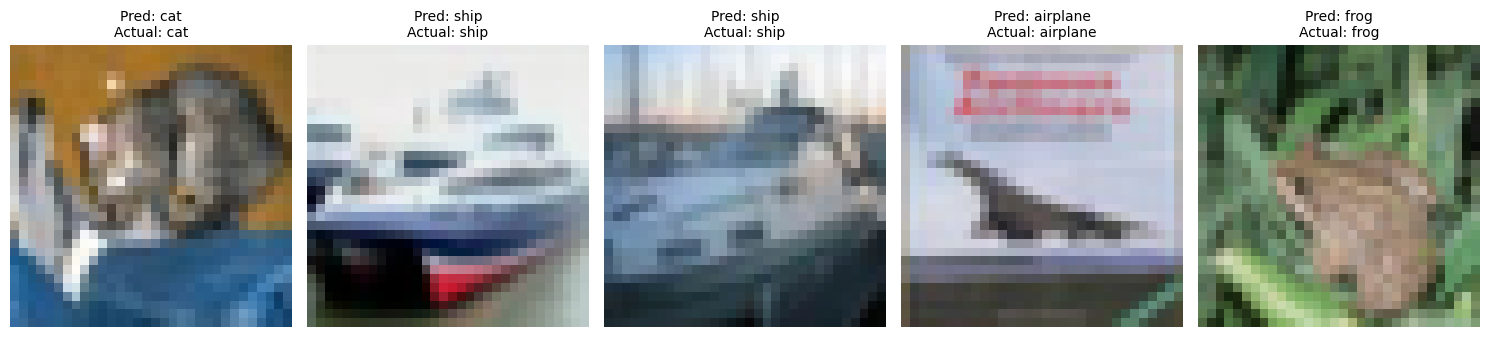

In [23]:


import matplotlib.pyplot as plt
import numpy as np


model = model_depth  
model.eval()  

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move images to the device
images = images.to(device)

# Get predictions from the model
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.max(1)

# Move predicted labels and true labels to CPU and convert to numpy arrays
predicted = predicted.cpu().numpy()
labels = labels.cpu().numpy()

# Get the class names from the dataset
classes = train_dataset.classes

# Define how many images you want to display
num_images = 5  

# Create a figure with subplots for each image
fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
for i in range(num_images):
    # Unnormalize the image to display in its natural colors
    img = images[i].cpu()  # Get image from GPU and move to CPU
    npimg = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.247, 0.243, 0.261])
    npimg = std * npimg + mean
    npimg = np.clip(npimg, 0, 1)
    
    # Display the image
    axes[i].imshow(npimg)
    axes[i].axis('off')
    
    # Set the title with predicted and actual label
    axes[i].set_title(f"Pred: {classes[predicted[i]]}\nActual: {classes[labels[i]]}", fontsize=10)

plt.tight_layout()
plt.show()
